In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import glob
import utils
import matplotlib.colors as colors
import cmaps
from statsmodels.nonparametric.smoothers_lowess import lowess as  sm_lowess
from scipy.stats import pearsonr, t as tdist
from scipy.stats import t

In [2]:
def pvalue_array(x,y,dname):
    x_an=x-x.mean(dname)
    y_an=y-y.mean(dname)
    slope=(x_an*y_an).sum(dname)/(x_an*x_an).sum(dname)
    interc=y.mean(dname)-slope*x.mean(dname)
    ypred=slope*x+interc
    n=len(x[dname])
    mse=np.sqrt(((y-ypred)**2).sum(dname)/(n-2))
    xsq=np.sqrt(((x_an)**2).sum(dname))
    standerr=mse/xsq
    pval=2*(1-t.cdf(np.abs(slope/standerr),n-2))
    pval=xr.DataArray(pval,dims=standerr.dims,coords=standerr.coords)
    return pval

def rvalue_array(x,y,dname):
    xmean=x.mean(dname)
    ymean=y.mean(dname)
    numer=(x*y).mean(dname)-xmean*ymean
    denom=np.sqrt(((x**2).mean(dname)-xmean**2)*(((y**2).mean(dname))-(ymean**2)))
    return numer/denom

def regcoeff_array(x,y,dname):
    x_an=x-x.mean(dname)
    y_an=y-y.mean(dname)
    slope=(x_an*y_an).sum(dname)/(x_an*x_an).sum(dname)
    return slope

def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg, skipna=True)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

def trend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg, skipna=True)
    return p

In [3]:
datadir='/Projects/RAPrototype/ERA5'
plotdir='/home/ghervieux/SCRIPTS/GEV/PLOTS'

In [4]:
state_borders =\
cartopy.feature.NaturalEarthFeature(category='cultural',\
        name='admin_1_states_provinces_lakes', scale='50m', facecolor='none')

In [6]:
yearb=1941
yeare=2023

# GLOST 

In [7]:
fileGLOST = f'/data/ghervieux/AFI/NOAA_GLOST_anomaly.csv'
df_glost=pd.read_csv(fileGLOST,skiprows=4)
df_glost['Year']=pd.to_datetime(df_glost['Year'], format='%Y%m')

In [8]:
ds_glost=df_glost.set_index(['Year']).to_xarray()
sm_x, smooth_glost = sm_lowess(ds_glost['Anomaly'], ds_glost['Year'],  frac=(30*12)/len(ds_glost['Year']), 
                           it=5, return_sorted = True).T
smooth_glost=xr.DataArray(smooth_glost,dims=['time'],coords={'time':ds_glost['Year'].data})  

In [9]:
def ann_mean(var):
    month_length = var.time.dt.days_in_month
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()
    var_ann = (var*wgts).groupby("time.year").sum()
    return var_ann

In [10]:
ann_glost=ann_mean(smooth_glost)
ann_glost=ann_glost.rename({'year':'time'})
ann_glost = ann_glost.sel(time=slice(yearb,yeare))
ann_glost = ann_glost.rename({'time':'year'})

# Read US: CONUS + Alaska mask ERA5

In [11]:
dsm=xr.open_dataset('/data/ghervieux/AFI/mask_usa_for_ERA5crop.nc')
mask=dsm['mask_usa'].load()

# Read Coldest Day ERA5

In [12]:
temp_var='coldest_tmin'
year=np.arange(yearb,yeare+1,1)

In [13]:
files=[f'{datadir}/Coldest_Day.era5.{iyear}.nc' for iyear in year]
dstmin = xr.open_mfdataset(files,combine='nested', concat_dim='year')
dstmin =dstmin.load()
dstmin['year'] = year.astype('int64')
units='$\degree$K'
trend_tmin = trend_dim(dstmin['coldest_tmin'].where(mask==1),'year')


<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_47945/1817706548.py:5: SyntaxWarning: invalid escape sequence '\d'
  units='$\degree$K'


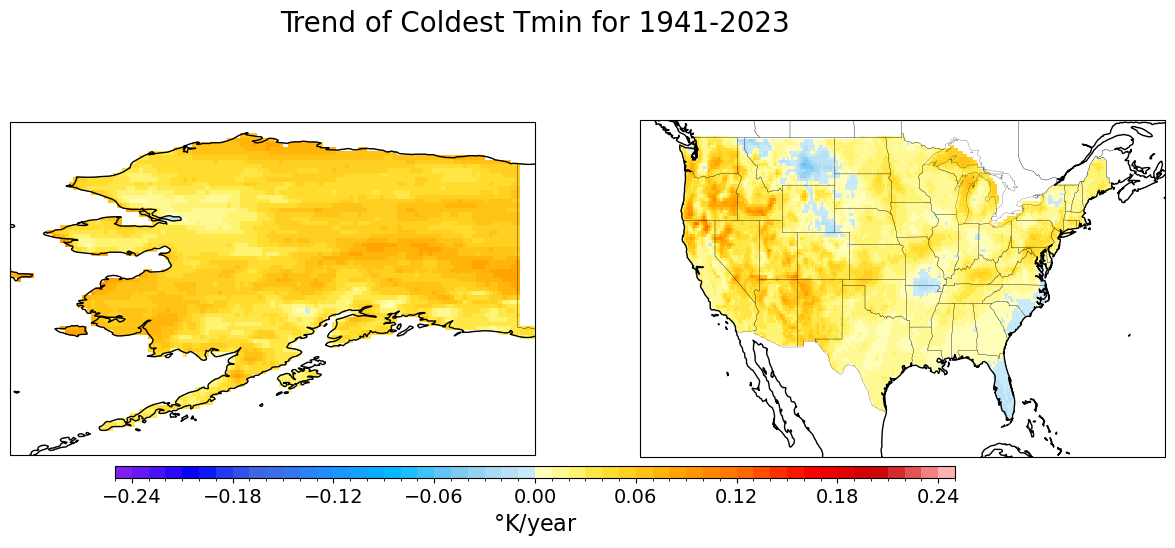

In [14]:
cmap=cmaps.ncl_default
proj=ccrs.PlateCarree()

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(14,6),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.15, right=0.95)
cc=trend_tmin['polyfit_coefficients'].sel(degree=1).plot.pcolormesh(ax=ax[0],cmap=cmap,levels=np.arange(-0.25,0.26,0.01),add_colorbar=False)
ax[0].set_extent([190,220,53,72],ccrs.PlateCarree())

cc=trend_tmin['polyfit_coefficients'].sel(degree=1).plot.pcolormesh(ax=ax[1],cmap=cmap,levels=np.arange(-0.25,0.26,0.01),add_colorbar=False)
ax[1].set_extent([230,300,22,50.5],ccrs.PlateCarree())


ax_cbar = fig.add_axes([0.2, 0.2, 0.6, 0.02])
cbar=fig.colorbar(cc,cax=ax_cbar,shrink=0.5,orientation='horizontal')
cbar.ax.tick_params(labelsize=14)  
cbar.set_label(label=f'{units}/year',fontsize=16)


asp = np.diff(ax[0].get_xlim())[0] / np.diff(ax[0].get_ylim())[0]
ax[1].set_aspect(asp)

for i in range(len(ax)):
  ax[i].add_feature(state_borders,zorder=100,edgecolor='k',linewidth=0.15)
  ax[i].coastlines()
  ax[i].set_title('')
plt.suptitle(f'Trend of Coldest Tmin for {yearb}-{yeare}',fontsize=20)  
outfile=f'PLOTS/Trend_Coldest_Tmin_{yearb}_{yeare}.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

# Read Hottest Day ERA5

In [15]:
temp_var='coldest_tmax'
year=np.arange(yearb,yeare+1,1)

In [16]:
files=[f'{datadir}/Hottest_Day.era5.{iyear}.nc' for iyear in year]
dstmax = xr.open_mfdataset(files,combine='nested', concat_dim='year')
dstmax =dstmax.load()
dstmax['year'] = year.astype('int64')
units='$\degree$K'
trend_tmax = trend_dim(dstmax['hottest_tmax'].where(mask==1),'year')

<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_47945/191892397.py:5: SyntaxWarning: invalid escape sequence '\d'
  units='$\degree$K'


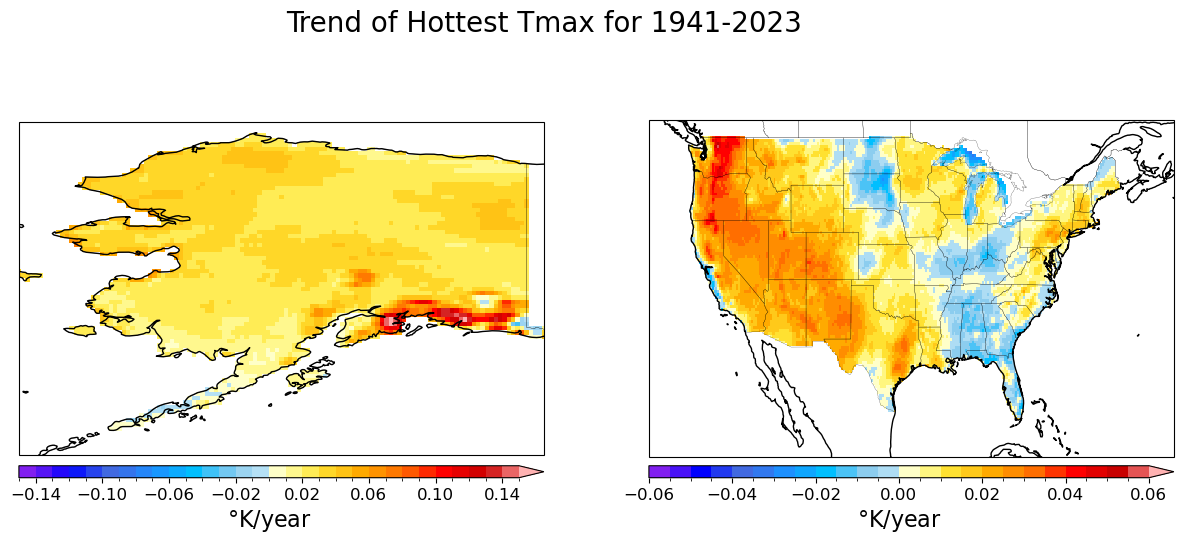

In [17]:
cmap=cmaps.ncl_default
proj=ccrs.PlateCarree()

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(14,6),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.15, right=0.95)

clevs = np.arange(-0.15,0.16,0.01)
cc=trend_tmax['polyfit_coefficients'].sel(degree=1).plot.pcolormesh(ax=ax[0],cmap=cmap,levels=clevs,add_colorbar=False)
ax[0].set_extent([190,220,53,72],ccrs.PlateCarree())
p0 = ax[0].get_position().get_points().flatten()
ax_cbar = fig.add_axes([p0[0], 0.2, p0[2]-p0[0], 0.02])
cbar=fig.colorbar(cc,cax=ax_cbar,ticks=clevs[1::4],shrink=0.5,orientation='horizontal')
cbar.ax.tick_params(labelsize=12)  
cbar.set_label(label=f'{units}/year',fontsize=16)

clevs = np.arange(-0.06,0.065,0.005)
cc=trend_tmax['polyfit_coefficients'].sel(degree=1).plot.pcolormesh(ax=ax[1],cmap=cmap,levels=clevs,add_colorbar=False)
ax[1].set_extent([230,300,22,50.5],ccrs.PlateCarree())
p0 = ax[1].get_position().get_points().flatten()
ax_cbar = fig.add_axes([p0[0], 0.2, p0[2]-p0[0], 0.02])
cbar=fig.colorbar(cc,cax=ax_cbar,ticks=clevs[::4],shrink=0.5,orientation='horizontal')
cbar.ax.tick_params(labelsize=12)  
cbar.set_label(label=f'{units}/year',fontsize=16)


asp = np.diff(ax[0].get_xlim())[0] / np.diff(ax[0].get_ylim())[0]
ax[1].set_aspect(asp)

for i in range(len(ax)):
  ax[i].add_feature(state_borders,zorder=100,edgecolor='k',linewidth=0.15)
  ax[i].coastlines()
  ax[i].set_title('')
plt.suptitle(f'Trend of Hottest Tmax for {yearb}-{yeare}',fontsize=20)  
outfile=f'PLOTS/Trend_Hottest_Tmax_{yearb}_{yeare}.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

# Timeseries

In [18]:
ptlon = [211.25  ,211.,260,251.25]
ptlat = [ 60.5, 64.75, 46, 38.   ]

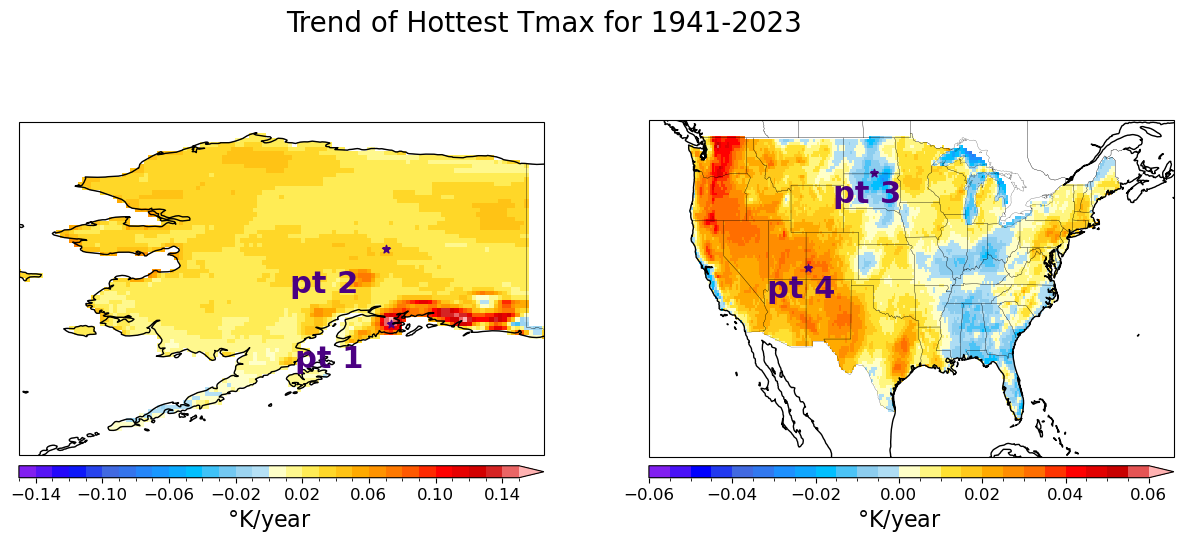

In [19]:
cmap=cmaps.ncl_default
proj=ccrs.PlateCarree()

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(14,6),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.15, right=0.95)

clevs = np.arange(-0.15,0.16,0.01)
cc=trend_tmax['polyfit_coefficients'].sel(degree=1).plot.pcolormesh(ax=ax[0],cmap=cmap,levels=clevs,add_colorbar=False)
ax[0].set_extent([190,220,53,72],ccrs.PlateCarree())
for ip in range(0,2):
  ax[0].scatter(ptlon[ip],ptlat[ip],marker='*',color='indigo')
  ax[0].text(ptlon[ip]-360-5.5,ptlat[ip]-2.5,f'pt {ip+1}',color='indigo',size=22,weight='bold')
p0 = ax[0].get_position().get_points().flatten()
ax_cbar = fig.add_axes([p0[0], 0.2, p0[2]-p0[0], 0.02])
cbar=fig.colorbar(cc,cax=ax_cbar,ticks=clevs[1::4],shrink=0.5,orientation='horizontal')
cbar.ax.tick_params(labelsize=12)  
cbar.set_label(label=f'{units}/year',fontsize=16)

clevs = np.arange(-0.06,0.065,0.005)
cc=trend_tmax['polyfit_coefficients'].sel(degree=1).plot.pcolormesh(ax=ax[1],cmap=cmap,levels=clevs,add_colorbar=False)
ax[1].set_extent([230,300,22,50.5],ccrs.PlateCarree())
for ip in range(2,len(ptlon)):
  ax[1].scatter(ptlon[ip],ptlat[ip],marker='*',color='indigo')
  ax[1].text(ptlon[ip]-360-5.5,ptlat[ip]-2.5,f'pt {ip+1}',color='indigo',size=22,weight='bold')
p0 = ax[1].get_position().get_points().flatten()
ax_cbar = fig.add_axes([p0[0], 0.2, p0[2]-p0[0], 0.02])
cbar=fig.colorbar(cc,cax=ax_cbar,ticks=clevs[::4],shrink=0.5,orientation='horizontal')
cbar.ax.tick_params(labelsize=12)  
cbar.set_label(label=f'{units}/year',fontsize=16)


asp = np.diff(ax[0].get_xlim())[0] / np.diff(ax[0].get_ylim())[0]
ax[1].set_aspect(asp)

for i in range(len(ax)):
  ax[i].add_feature(state_borders,zorder=100,edgecolor='k',linewidth=0.15)
  ax[i].coastlines()
  ax[i].set_title('')
plt.suptitle(f'Trend of Hottest Tmax for {yearb}-{yeare}',fontsize=20)  
outfile=f'PLOTS/Trend_Hottest_Tmax_{yearb}_{yeare}.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

<>:16: SyntaxWarning: invalid escape sequence '\d'
<>:16: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_47945/2563642500.py:16: SyntaxWarning: invalid escape sequence '\d'
  ax1.set_ylabel(f'Tmin ($\degree$K)', color='k',fontsize=16)


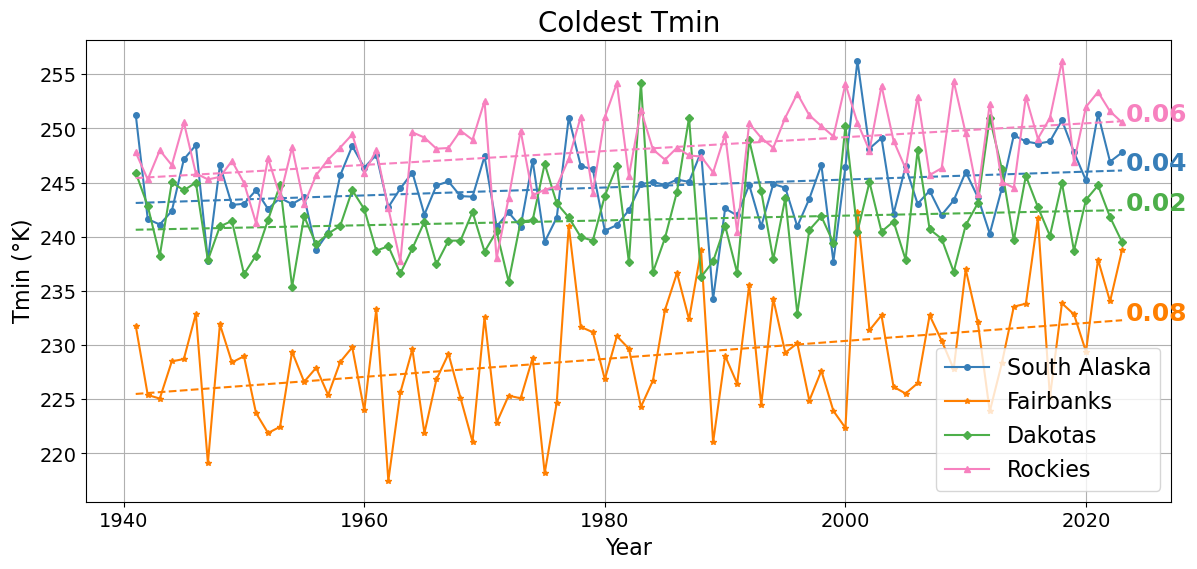

In [20]:
colors = ['#377eb8','#ff7f00', '#4daf4a','#f781bf']
markers = ['o','*','D','^']
Tlabels=['South Alaska','Fairbanks','Dakotas','Rockies']
#####
fig, ax1 = plt.subplots(figsize=(14,6))
#ax2 = ax1.twinx()
for ij in range(len(ptlon)): 
  ax1.plot(np.arange(yearb,yeare+1,1),dstmin['coldest_tmin'].sel(lon=ptlon[ij],lat=ptlat[ij]),\
           color=colors[ij],marker=markers[ij],markersize=4,label=f'{Tlabels[ij]}')
  lines=np.arange(yearb,yeare+1,1)*trend_tmin['polyfit_coefficients'].sel(degree=1).sel(lon=ptlon[ij],lat=ptlat[ij]).values + \
trend_tmin['polyfit_coefficients'].sel(degree=0).sel(lon=ptlon[ij],lat=ptlat[ij]).values
  ax1.plot(np.arange(yearb,yeare+1,1),lines,
           color=colors[ij],linestyle='--')
  ax1.text(yeare+0.3,lines[-1],f'{trend_tmin['polyfit_coefficients'].sel(degree=1).sel(lon=ptlon[ij],lat=ptlat[ij]).values:0.2f}',color=colors[ij],size=18,weight='bold')

ax1.set_ylabel(f'Tmin ($\degree$K)', color='k',fontsize=16)
ax1.tick_params(axis='x', labelcolor='k',labelsize=14)
ax1.tick_params(axis='y', labelcolor='k',labelsize=14)
ax1.set_xlabel('Year',fontsize=16)
ax1.grid()
ax1.legend(fontsize=16)
ax1.set_title('Coldest Tmin',fontsize=20)
outfile=f'PLOTS/Coldest_Tmin_timeseries.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

<>:16: SyntaxWarning: invalid escape sequence '\d'
<>:16: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_47945/1354012752.py:16: SyntaxWarning: invalid escape sequence '\d'
  ax1.set_ylabel(f'Tmax ($\degree$K)', color='k',fontsize=16)


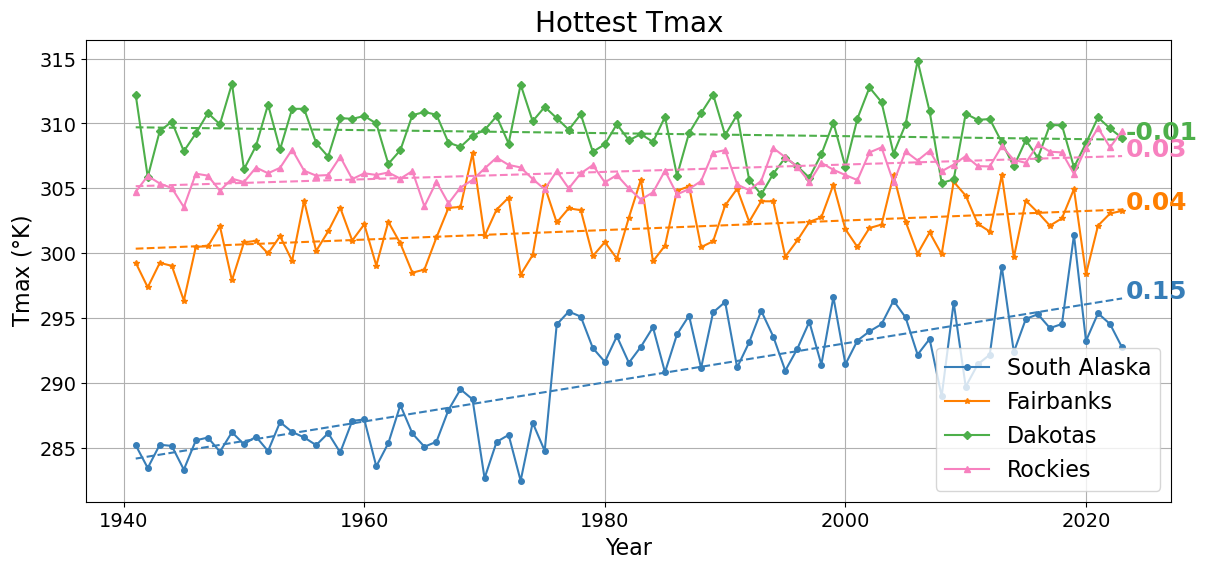

In [21]:
colors = ['#377eb8','#ff7f00', '#4daf4a','#f781bf']
markers = ['o','*','D','^']
Tlabels=['South Alaska','Fairbanks','Dakotas','Rockies']
#####
fig, ax1 = plt.subplots(figsize=(14,6))
#ax2 = ax1.twinx()
for ij in range(len(ptlon)): 
  ax1.plot(np.arange(yearb,yeare+1,1),dstmax['hottest_tmax'].sel(lon=ptlon[ij],lat=ptlat[ij]),\
           color=colors[ij],marker=markers[ij],markersize=4,label=f'{Tlabels[ij]}')
  lines=np.arange(yearb,yeare+1,1)*trend_tmax['polyfit_coefficients'].sel(degree=1).sel(lon=ptlon[ij],lat=ptlat[ij]).values + \
trend_tmax['polyfit_coefficients'].sel(degree=0).sel(lon=ptlon[ij],lat=ptlat[ij]).values
  ax1.plot(np.arange(yearb,yeare+1,1),lines,
           color=colors[ij],linestyle='--')
  ax1.text(yeare+0.3,lines[-1],f'{trend_tmax['polyfit_coefficients'].sel(degree=1).sel(lon=ptlon[ij],lat=ptlat[ij]).values:0.2f}',color=colors[ij],size=18,weight='bold')

ax1.set_ylabel(f'Tmax ($\degree$K)', color='k',fontsize=16)
ax1.tick_params(axis='x', labelcolor='k',labelsize=14)
ax1.tick_params(axis='y', labelcolor='k',labelsize=14)
ax1.set_xlabel('Year',fontsize=16)
ax1.grid()
ax1.legend(fontsize=16)
ax1.set_title('Hottest Tmax',fontsize=20)
outfile=f'PLOTS/Hottest_Tmax_timeseries.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

# Regression onto GLOST

In [62]:
reg_tmin = regcoeff_array(dstmin['coldest_tmin'].where(mask==1),ann_glost,'year')
reg_tmax = regcoeff_array(dstmax['hottest_tmax'].where(mask==1),ann_glost,'year')

In [63]:
print(reg_tmin.min().values,reg_tmin.max().values)
print(reg_tmax.min().values,reg_tmax.max().values)

-0.014091148881174867 0.11013245167888008
-0.08720847370987408 0.21015418800554697


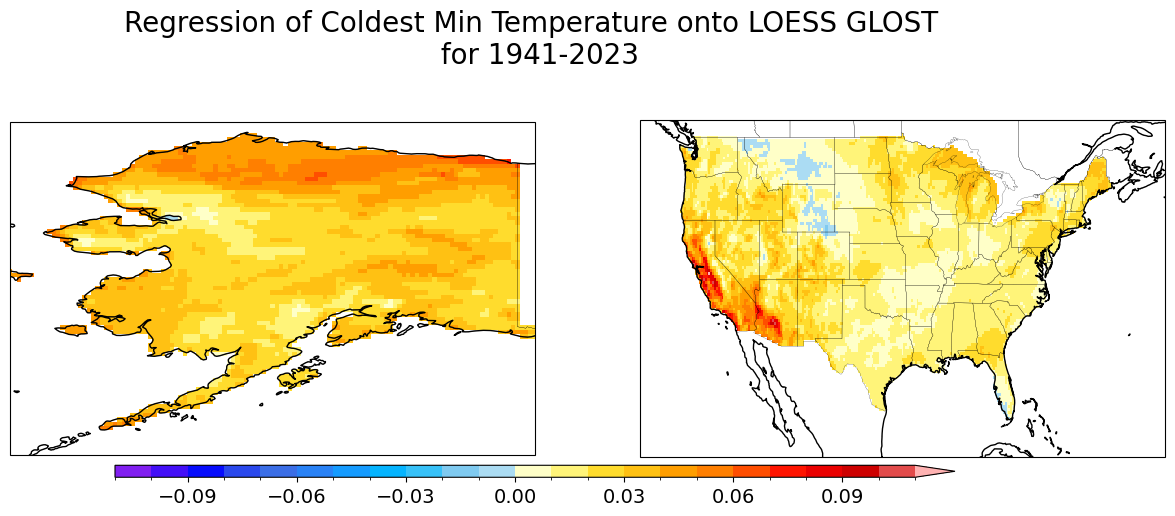

In [64]:
cmap=cmaps.ncl_default
proj=ccrs.PlateCarree()

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(14,6),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.15, right=0.95)

cc=reg_tmin.plot.pcolormesh(ax=ax[0],cmap=cmap,levels=np.arange(-0.11,0.12,0.01),add_colorbar=False)
ax[0].set_extent([190,220,53,72],ccrs.PlateCarree())

cc=reg_tmin.plot.pcolormesh(ax=ax[1],cmap=cmap,levels=np.arange(-0.11,0.12,0.01),add_colorbar=False)
ax[1].set_extent([230,300,22,50.5],ccrs.PlateCarree())

ax_cbar = fig.add_axes([0.2, 0.2, 0.6, 0.02])
cbar=fig.colorbar(cc,cax=ax_cbar,shrink=0.5,orientation='horizontal')
cbar.ax.tick_params(labelsize=14)  
cbar.set_label(label=f'',fontsize=16)

asp = np.diff(ax[0].get_xlim())[0] / np.diff(ax[0].get_ylim())[0]
ax[1].set_aspect(asp)

for i in range(len(ax)):
  ax[i].add_feature(state_borders,zorder=100,edgecolor='k',linewidth=0.15)
  ax[i].coastlines()
  ax[i].set_title('')
plt.suptitle(f'Regression of Coldest Min Temperature onto LOESS GLOST \n for {yearb}-{yeare}',fontsize=20)  
outfile=f'PLOTS/Regression_Coldest_Tmin_GLOST_{yearb}_{yeare}.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

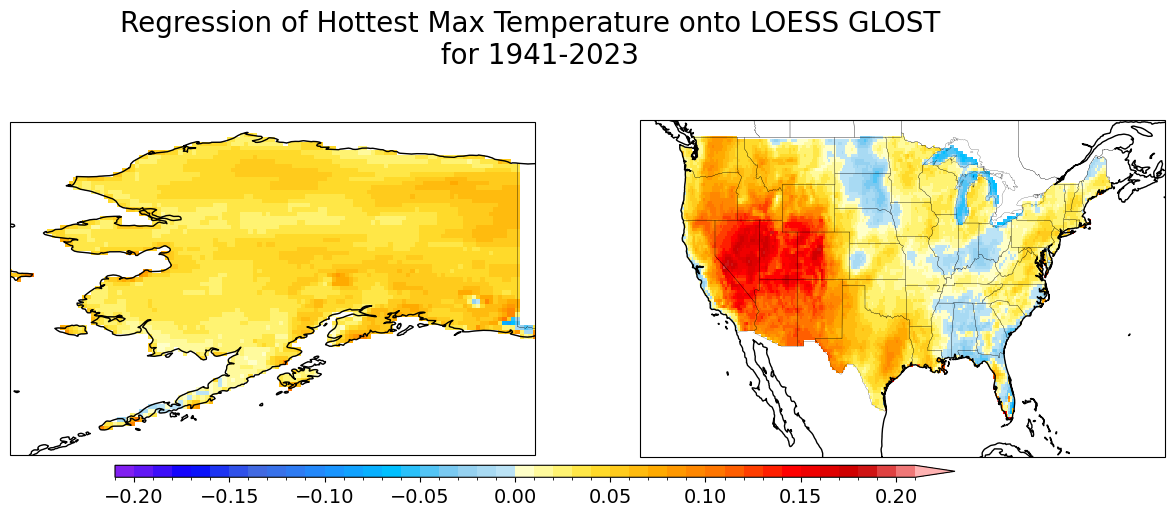

In [65]:
cmap=cmaps.ncl_default
proj=ccrs.PlateCarree()

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(14,6),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.15, right=0.95)

cc=reg_tmax.plot.pcolormesh(ax=ax[0],cmap=cmap,levels=np.arange(-0.21,0.22,0.01),add_colorbar=False)
ax[0].set_extent([190,220,53,72],ccrs.PlateCarree())

cc=reg_tmax.plot.pcolormesh(ax=ax[1],cmap=cmap,levels=np.arange(-0.21,0.22,0.01),add_colorbar=False)
ax[1].set_extent([230,300,22,50.5],ccrs.PlateCarree())

ax_cbar = fig.add_axes([0.2, 0.2, 0.6, 0.02])
cbar=fig.colorbar(cc,cax=ax_cbar,shrink=0.5,orientation='horizontal')
cbar.ax.tick_params(labelsize=14)  
cbar.set_label(label=f'',fontsize=16)

asp = np.diff(ax[0].get_xlim())[0] / np.diff(ax[0].get_ylim())[0]
ax[1].set_aspect(asp)

for i in range(len(ax)):
  ax[i].add_feature(state_borders,zorder=100,edgecolor='k',linewidth=0.15)
  ax[i].coastlines()
  ax[i].set_title('')
plt.suptitle(f'Regression of Hottest Max Temperature onto LOESS GLOST \n for {yearb}-{yeare}',fontsize=20)  
outfile=f'PLOTS/Regression_Hottest_Tmax_GLOST_{yearb}_{yeare}.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

# Correlation onto GLOST

In [66]:
cor_tmin = rvalue_array(dstmin['coldest_tmin'].where(mask==1),ann_glost,'year')
cor_tmax = rvalue_array(dstmax['hottest_tmax'].where(mask==1),ann_glost,'year')

pvalue_tmin = pvalue_array(dstmin['coldest_tmin'].where(mask==1),ann_glost,'year')
pvalue_tmax = pvalue_array(dstmax['hottest_tmax'].where(mask==1),ann_glost,'year')

In [67]:
print(cor_tmin.min().values,cor_tmin.max().values)
print(cor_tmax.min().values,cor_tmax.max().values)

-0.14738596509205598 0.6812521109104447
-0.46608011652110315 0.7867831023861713


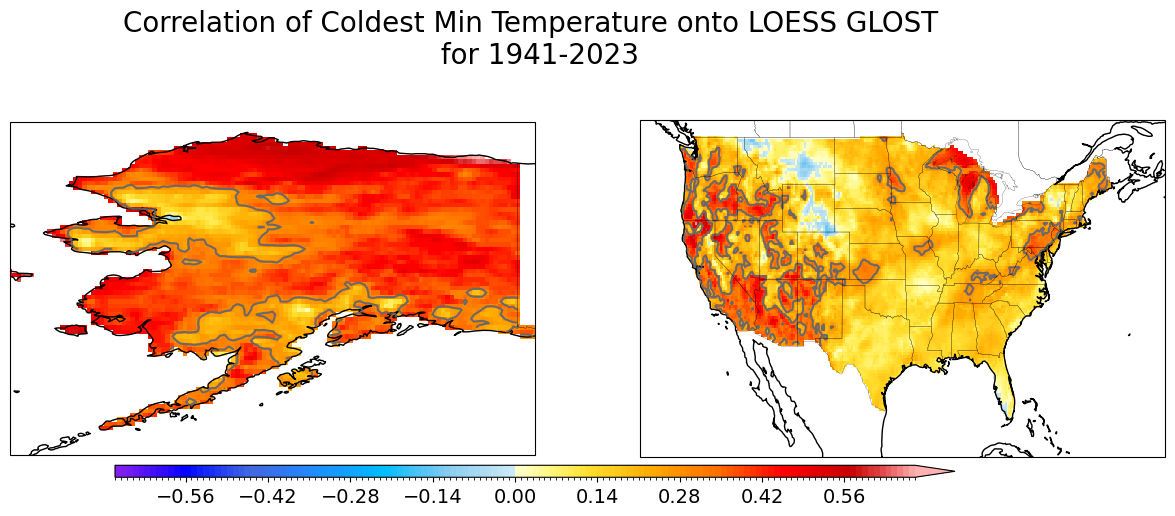

In [68]:
cmap=cmaps.ncl_default
proj=ccrs.PlateCarree()

clevs = np.arange(-0.68,.69,0.01)
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(14,6),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.15, right=0.95)

cc=cor_tmin.plot.pcolormesh(ax=ax[0],cmap=cmap,levels=clevs,add_colorbar=False)
ax[0].contour(pvalue_tmin['lon'],pvalue_tmin['lat'],pvalue_tmin,levels=[0.01],colors='dimgrey')
ax[0].set_extent([190,220,53,72],ccrs.PlateCarree())

cc=cor_tmin.plot.pcolormesh(ax=ax[1],cmap=cmap,levels=clevs,add_colorbar=False)
ax[1].contour(pvalue_tmin['lon'],pvalue_tmin['lat'],pvalue_tmin,levels=[0.01],colors='dimgrey')
ax[1].set_extent([230,300,22,50.5],ccrs.PlateCarree())

ax_cbar = fig.add_axes([0.2, 0.2, 0.6, 0.02])
cbar=fig.colorbar(cc,cax=ax_cbar,shrink=0.5,orientation='horizontal')
cbar.ax.tick_params(labelsize=14)  
cbar.set_label(label=f'',fontsize=16)

asp = np.diff(ax[0].get_xlim())[0] / np.diff(ax[0].get_ylim())[0]
ax[1].set_aspect(asp)

for i in range(len(ax)):
  ax[i].add_feature(state_borders,zorder=100,edgecolor='k',linewidth=0.15)
  ax[i].coastlines()
  ax[i].set_title('')
plt.suptitle(f'Correlation of Coldest Min Temperature onto LOESS GLOST \n for {yearb}-{yeare}',fontsize=20)  
outfile=f'PLOTS/Correlation_Coldest_tmin_GLOST_{yearb}_{yeare}.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

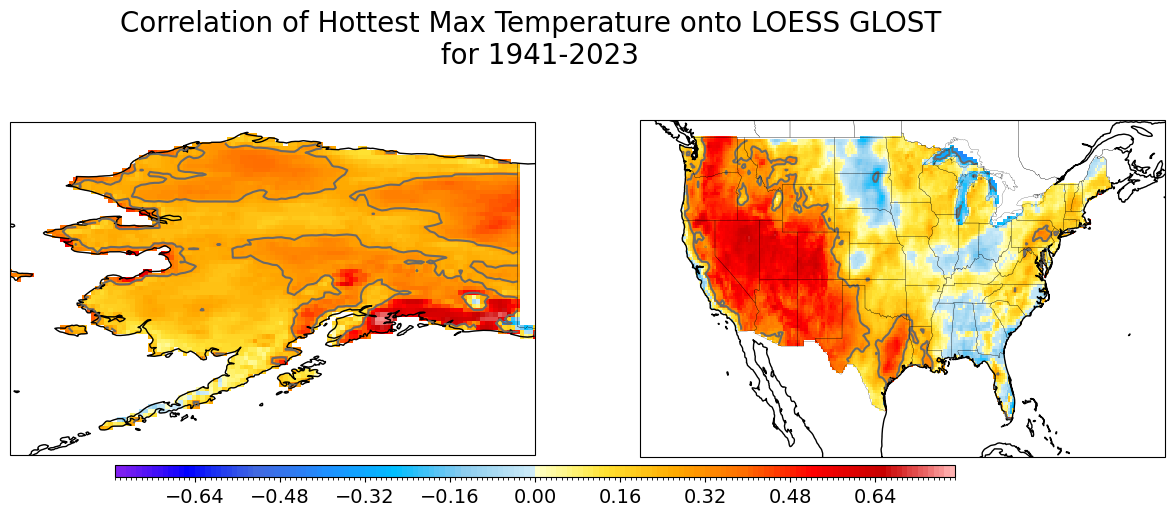

In [69]:
cmap=cmaps.ncl_default
proj=ccrs.PlateCarree()

clevs = np.arange(-0.79,.8,0.01)
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(14,6),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.15, right=0.95)

cc=cor_tmax.plot.pcolormesh(ax=ax[0],cmap=cmap,levels=clevs,add_colorbar=False)
ax[0].contour(pvalue_tmax['lon'],pvalue_tmax['lat'],pvalue_tmax,levels=[0.01],colors='dimgrey')
ax[0].set_extent([190,220,53,72],ccrs.PlateCarree())

cc=cor_tmax.plot.pcolormesh(ax=ax[1],cmap=cmap,levels=clevs,add_colorbar=False)
ax[1].contour(pvalue_tmax['lon'],pvalue_tmax['lat'],pvalue_tmax,levels=[0.01],colors='dimgrey')
ax[1].set_extent([230,300,22,50.5],ccrs.PlateCarree())

ax_cbar = fig.add_axes([0.2, 0.2, 0.6, 0.02])
cbar=fig.colorbar(cc,cax=ax_cbar,shrink=0.5,orientation='horizontal')
cbar.ax.tick_params(labelsize=14)  
cbar.set_label(label=f'',fontsize=16)

asp = np.diff(ax[0].get_xlim())[0] / np.diff(ax[0].get_ylim())[0]
ax[1].set_aspect(asp)

for i in range(len(ax)):
  ax[i].add_feature(state_borders,zorder=100,edgecolor='k',linewidth=0.15)
  ax[i].coastlines()
  ax[i].set_title('')
plt.suptitle(f'Correlation of Hottest Max Temperature onto LOESS GLOST \n for {yearb}-{yeare}',fontsize=20)  
outfile=f'PLOTS/Correlation_Hottest_tmax_GLOST_{yearb}_{yeare}.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')